<a href="https://colab.research.google.com/github/antoniovfonseca/agentic-ai-global-lulc/blob/main/notebooks/overview-glance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/antoniovfonseca/agentic-ai-global-lulc/blob/main/notebooks/overview-glance.ipynb)

# **Change Components Analysis (CCA)**

---



## **1. Setup and User Input**
Define your Google Cloud Project ID and the years of interest for the analysis here. The rest of the process is automated.

In [10]:
# 1.Enter your Google Cloud Project ID
project_id = "ee-avfonseca"

# 2.Define time points
years = [2001, 2010, 2019]

## **2. Environment Setup and Authentication**



In [11]:
import os
import sys
import warnings

# Filter future warnings to keep output clean
warnings.simplefilter(
    action='ignore',
    category=FutureWarning
    )

# Install dependencies
print("Installing dependencies...")
!pip install geemap -q
!pip install geedim -q
!pip install localtileserver -q
print("Installation finished successfully.")

Installing dependencies...
Installation finished successfully.


In [12]:
# Import libraries
import logging
import numpy as np
import ee
import geemap
import rasterio
from rasterio.warp import reproject, Resampling, transform_bounds

# Define repository details
repo_url = 'https://github.com/antoniovfonseca/agentic-ai-global-lulc.git'
repo_name = 'agentic-ai-global-lulc'

# Clone or update the repository
if not os.path.exists(repo_name):
    print(f"Cloning {repo_name}...")
    !git clone {repo_url}
else:
    print(f"Updating {repo_name}...")
    !cd {repo_name} && git pull

# Add the notebooks directory to system path to allow imports
notebooks_path = os.path.join(repo_name, 'notebooks')
if notebooks_path not in sys.path:
    sys.path.append(os.path.abspath(notebooks_path))
    print(f"Added {notebooks_path} to system path.")

import importlib
import utils

importlib.reload(utils)
print("Utils module loaded successfully.")

Updating agentic-ai-global-lulc...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.94 MiB | 9.96 MiB/s, done.
From https://github.com/antoniovfonseca/agentic-ai-global-lulc
   5df6df5..c98fd82  main       -> origin/main
Updating 5df6df5..c98fd82
Fast-forward
 notebooks/summarize_change_components_glance.ipynb | 8063 ++++++++++++++++++++
 1 file changed, 8063 insertions(+)
 create mode 100644 notebooks/summarize_change_components_glance.ipynb
Added agentic-ai-global-lulc/notebooks to system path.
Utils module loaded successfully.


In [13]:
# Authenticate and initialize earth engine
try:
    # Try initializing with the provided project id or default
    if project_id:
        ee.Initialize(project=project_id)
    else:
        ee.Initialize()
    print("Earth Engine initialized successfully.")

except Exception:
    # Trigger authentication flow if initialization fails
    print("Authentication required...")
    ee.Authenticate()

    try:
        # Retry initialization after authentication
        if project_id:
            ee.Initialize(project=project_id)
        else:
            ee.Initialize()
        print("Earth Engine initialized successfully.")

    except ee.EEException:
        # Fallback to manual input if no project is found
        print("No default project found.")
        manual_id = input("Please enter your Google Cloud Project ID: ")
        ee.Initialize(project=manual_id)
        print("Earth Engine initialized successfully.")

Earth Engine initialized successfully.


## **3. Visualization of GLANCE Land Cover**
Visualizes the Land Cover classification for a specific year directly from Google Earth Engine.

In [ ]:
# Define parameters
target_year = 2019

# Run the function imported from utils.py
glance_map = utils.get_glance_map(target_year)

# Display the map
if glance_map:
    display(glance_map)

## **4. Upload Region of Interest**
Upload the local `.tif` file that defines your study area. This file will be used as a mask to clip and filter the global GLANCE data.

In [ ]:
# Upload Raster File
print("Please upload your raster file (.tif):")

# This triggers the file upload widget
uploaded = files.upload()

# Automatically get the filename of the uploaded file
if uploaded:
    raster_filename = list(uploaded.keys())[0]
    print(f"\nFile '{raster_filename}' uploaded successfully.")
else:
    raise ValueError("No file uploaded. Please run the cell again and select a file.")

## **5. Download and Mask GLANCE Data**
This step downloads the GLANCE land cover data for the selected years within your region of interest and applies the local mask to filter the pixels.

In [ ]:
# Suppress warnings
logging.getLogger('googleapiclient.http').setLevel(logging.ERROR)
logging.getLogger('urllib3.connectionpool').setLevel(logging.ERROR)

# Define directories
masked_dir = utils.DEFAULT_INPUT_DIR
base_dir = os.path.dirname(masked_dir)
raw_dir = os.path.join(base_dir, 'raw')

# Create directories if they do not exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(masked_dir, exist_ok=True)

# Get geometry from local mask
with rasterio.open(raster_filename) as src:
    left, bottom, right, top = src.bounds
    if src.crs != 'EPSG:4326':
        left, bottom, right, top = transform_bounds(
            src.crs,
            'EPSG:4326',
            left,
            bottom,
            right,
            top
        )
    region = ee.Geometry.Rectangle([left, bottom, right, top])

# Process each year
for year in years:
    filename = f"glance_{year}.tif"
    raw_path = os.path.join(raw_dir, filename)
    masked_path = os.path.join(masked_dir, filename)

    # Skip if final masked file exists
    if os.path.exists(masked_path):
        print(f"Skipping {year} (masked file exists).")
        continue

    print(f"Processing year {year}...")

    # 1. Download raw data to raw folder
    if not os.path.exists(raw_path):
        try:
            image = ee.ImageCollection(utils.GLANCE_COLLECTION_ID) \
                .filterDate(f"{year}-01-01", f"{year}-12-31") \
                .mosaic() \
                .select(utils.GLANCE_CLASS_BAND) \
                .clip(region)

            geemap.download_ee_image(
                image,
                filename=raw_path,
                region=region,
                scale=30,
                crs='EPSG:4326',
                unmask_value=0,
                num_threads=1
            )
        except Exception as e:
            print(f"Error downloading {year}: {e}")
            continue

    # 2. Apply local mask and save to masked folder
    try:
        with rasterio.open(raster_filename) as mask_src:
            mask_data = mask_src.read(1)
            kwargs = mask_src.profile.copy()

            with rasterio.open(raw_path) as glance_src:
                glance_aligned = np.zeros(
                    mask_data.shape,
                    dtype=np.uint8
                )

                reproject(
                    source=rasterio.band(glance_src, 1),
                    destination=glance_aligned,
                    src_transform=glance_src.transform,
                    src_crs=glance_src.crs,
                    dst_transform=mask_src.transform,
                    dst_crs=mask_src.crs,
                    resampling=Resampling.nearest
                )

        # Apply mask logic (1 keeps value, others become 255)
        final_data = np.full(mask_data.shape, utils.NODATA_VALUE, dtype=np.uint8)
        valid_pixels = (mask_data == 1)
        final_data[valid_pixels] = glance_aligned[valid_pixels]

        # Update profile: fix block size to avoid "multiples of 16" error
        kwargs.update(
            dtype=rasterio.uint8,
            nodata=utils.NODATA_VALUE,
            compress='deflate',
            predictor=2,
            tiled=True,
            blockxsize=256,
            blockysize=256
        )

        with rasterio.open(masked_path, 'w', **kwargs) as dst:
            dst.write(final_data, 1)

        print(f"Finished: {masked_path}")

    except Exception as e:
        print(f"Error masking {year}: {e}")

Skipping 2001 (masked file exists).
Skipping 2010 (masked file exists).
Skipping 2019 (masked file exists).


## **6. Visualization of Processed Maps for the Region**
This section displays the interactive maps of the processed land cover data specifically for your region of interest, allowing you to observe the spatial distribution of classes across the selected years.

In [ ]:
# Visualize local files to validate the masking process
m = utils.view_local_rasters()

if m:
    display(m)

## **7. Class Size per Time Point**
This step quantifies the area (pixel count) of each land cover class for every analyzed year. It generates a stacked bar chart to visualize the temporal evolution of class sizes and displays the detailed statistics.

Starting processing...


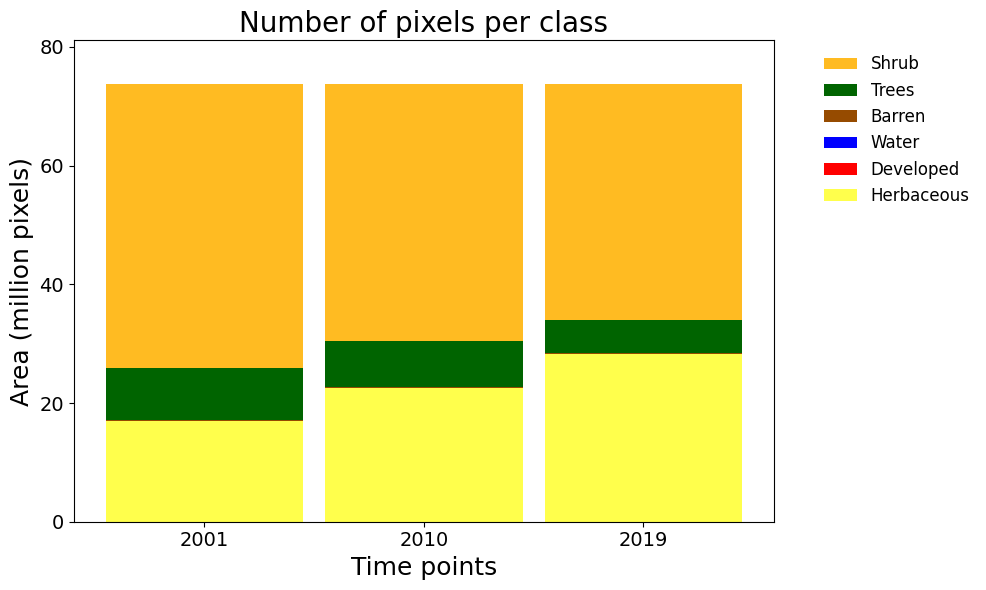

Files saved to: /content/glance_data/output

Processing complete. Data summary:


ClassName,Barren,Developed,Herbaceous,Shrub,Trees,Water
Year,,,,,,
2001,162892,67980,16901516,47839633,8727588,30934
2010,176131,70553,22504467,43259711,7689932,29749
2019,142967,71426,28181158,39672085,5637200,25707


In [ ]:
print("Starting processing...")

# Run the function using default settings from utils.py
df_result = utils.process_and_plot_pixel_counts()

# Display results if successful
if df_result is not None:
    print("\nProcessing complete. Data summary:")
    display(df_result)

## **8. Change Component Analysis (CCA)**
